In [19]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sys
sys.path.append('modeling')
from viz import viz_interactive, viz
from modeling import exponential_modeling
from bokeh.plotting import figure, show, output_notebook, output_file, save
from functions import merge_data
import load_data
from plotly.offline import init_notebook_mode, iplot
from fit_and_predict import add_preds
import json
from functions import update_severity_index as severity_index
plt.style.use('dark_background')
df = load_data.load_county_level()
df = df.sort_values('tot_deaths', ascending=False)
df = add_preds(df, NUM_DAYS_LIST=[1, 2, 3], cached_dir='data') # adds keys like "Predicted Deaths 1-day"
important_vars = load_data.important_keys(df)
print(df.keys())
df['tot_deaths_per_capita'] = df['tot_deaths'] / df['PopulationEstimate2018']
df['tot_cases_per_capita'] = df['tot_cases'] / df['PopulationEstimate2018']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Index(['id', 'Header-FIPSStandCtyCode', 'EntityofFile',
       'SecondaryEntityOfFile', 'DateofFile', 'DateofCreation', 'FileLength',
       'StateName', 'StateNameAbbreviation', 'CountyName',
       ...
       'y_preds_0', 'y_preds_1', 'y_preds_2', 'Predicted Deaths 1-day',
       'Predicted Deaths 2-day', 'Predicted Deaths 3-day',
       'Predicted Deaths 4-day', 'Predicted Deaths 5-day',
       'Predicted Deaths 6-day', 'Predicted Deaths 7-day'],
      dtype='object', length=7353)


## how many deaths/cases are there

In [ ]:
df[['tot_deaths', 'tot_cases', 'StateName', 'CountyName', 'Predicted Deaths 1-day']].head(10)

In [ ]:
# s = f'Predicted Deaths {2}-day' # tot_deaths
s = 'tot_deaths'
num_days = 1
nonzero = df[s] > 0
plt.figure(dpi=300, figsize=(7, 3))
plt.plot(df[s].values, '.', ms=3)
plt.ylabel(s)
plt.xlabel('Counties')
# plt.yscale('log')
plt.tight_layout()
plt.show()

In [ ]:
R, C = 1, 2
NUM_COUNTIES = 9
plt.figure(dpi=500, figsize=(8, 4))


# cs = sns.diverging_palette(20, 220, n=NUM_COUNTIES)
cs = sns.color_palette("husl", NUM_COUNTIES)
for i in range(NUM_COUNTIES):
    row = df.iloc[i]
    deaths = np.array([x for x in row['deaths'] if x > 0])
    cases = np.array([x for x in row['cases'] if x > 0])
    
    CASES_ALIGNMENT = 100
    idx_align = np.where(cases > CASES_ALIGNMENT)[0][0]
    n = cases.size
    
    DEATHS_ALIGNMENT = 10
    idx_align_deaths = np.where(deaths > DEATHS_ALIGNMENT)[0][0]
    n2 = deaths.size

    
    plt.subplot(R, C, 1)
    plt.plot(np.arange(n) - idx_align, cases, alpha=0.5, label=row['CountyName'] + ' County')#, color=cs[i])
#     plt.yscale('log')
    plt.ylabel('Cumulative confirmed cases')
    plt.xlabel(f'Days since {CASES_ALIGNMENT} cases')
    plt.legend()
    
    plt.subplot(R, C, 2)
    plt.plot(np.arange(n2) - idx_align_deaths, deaths, alpha=0.5, color=cs[i])
#     plt.yscale('log')
    plt.ylabel('Cumulative deaths')
    plt.xlabel(f'Days since {DEATHS_ALIGNMENT} deaths')
plt.tight_layout()
plt.show()

# correlations

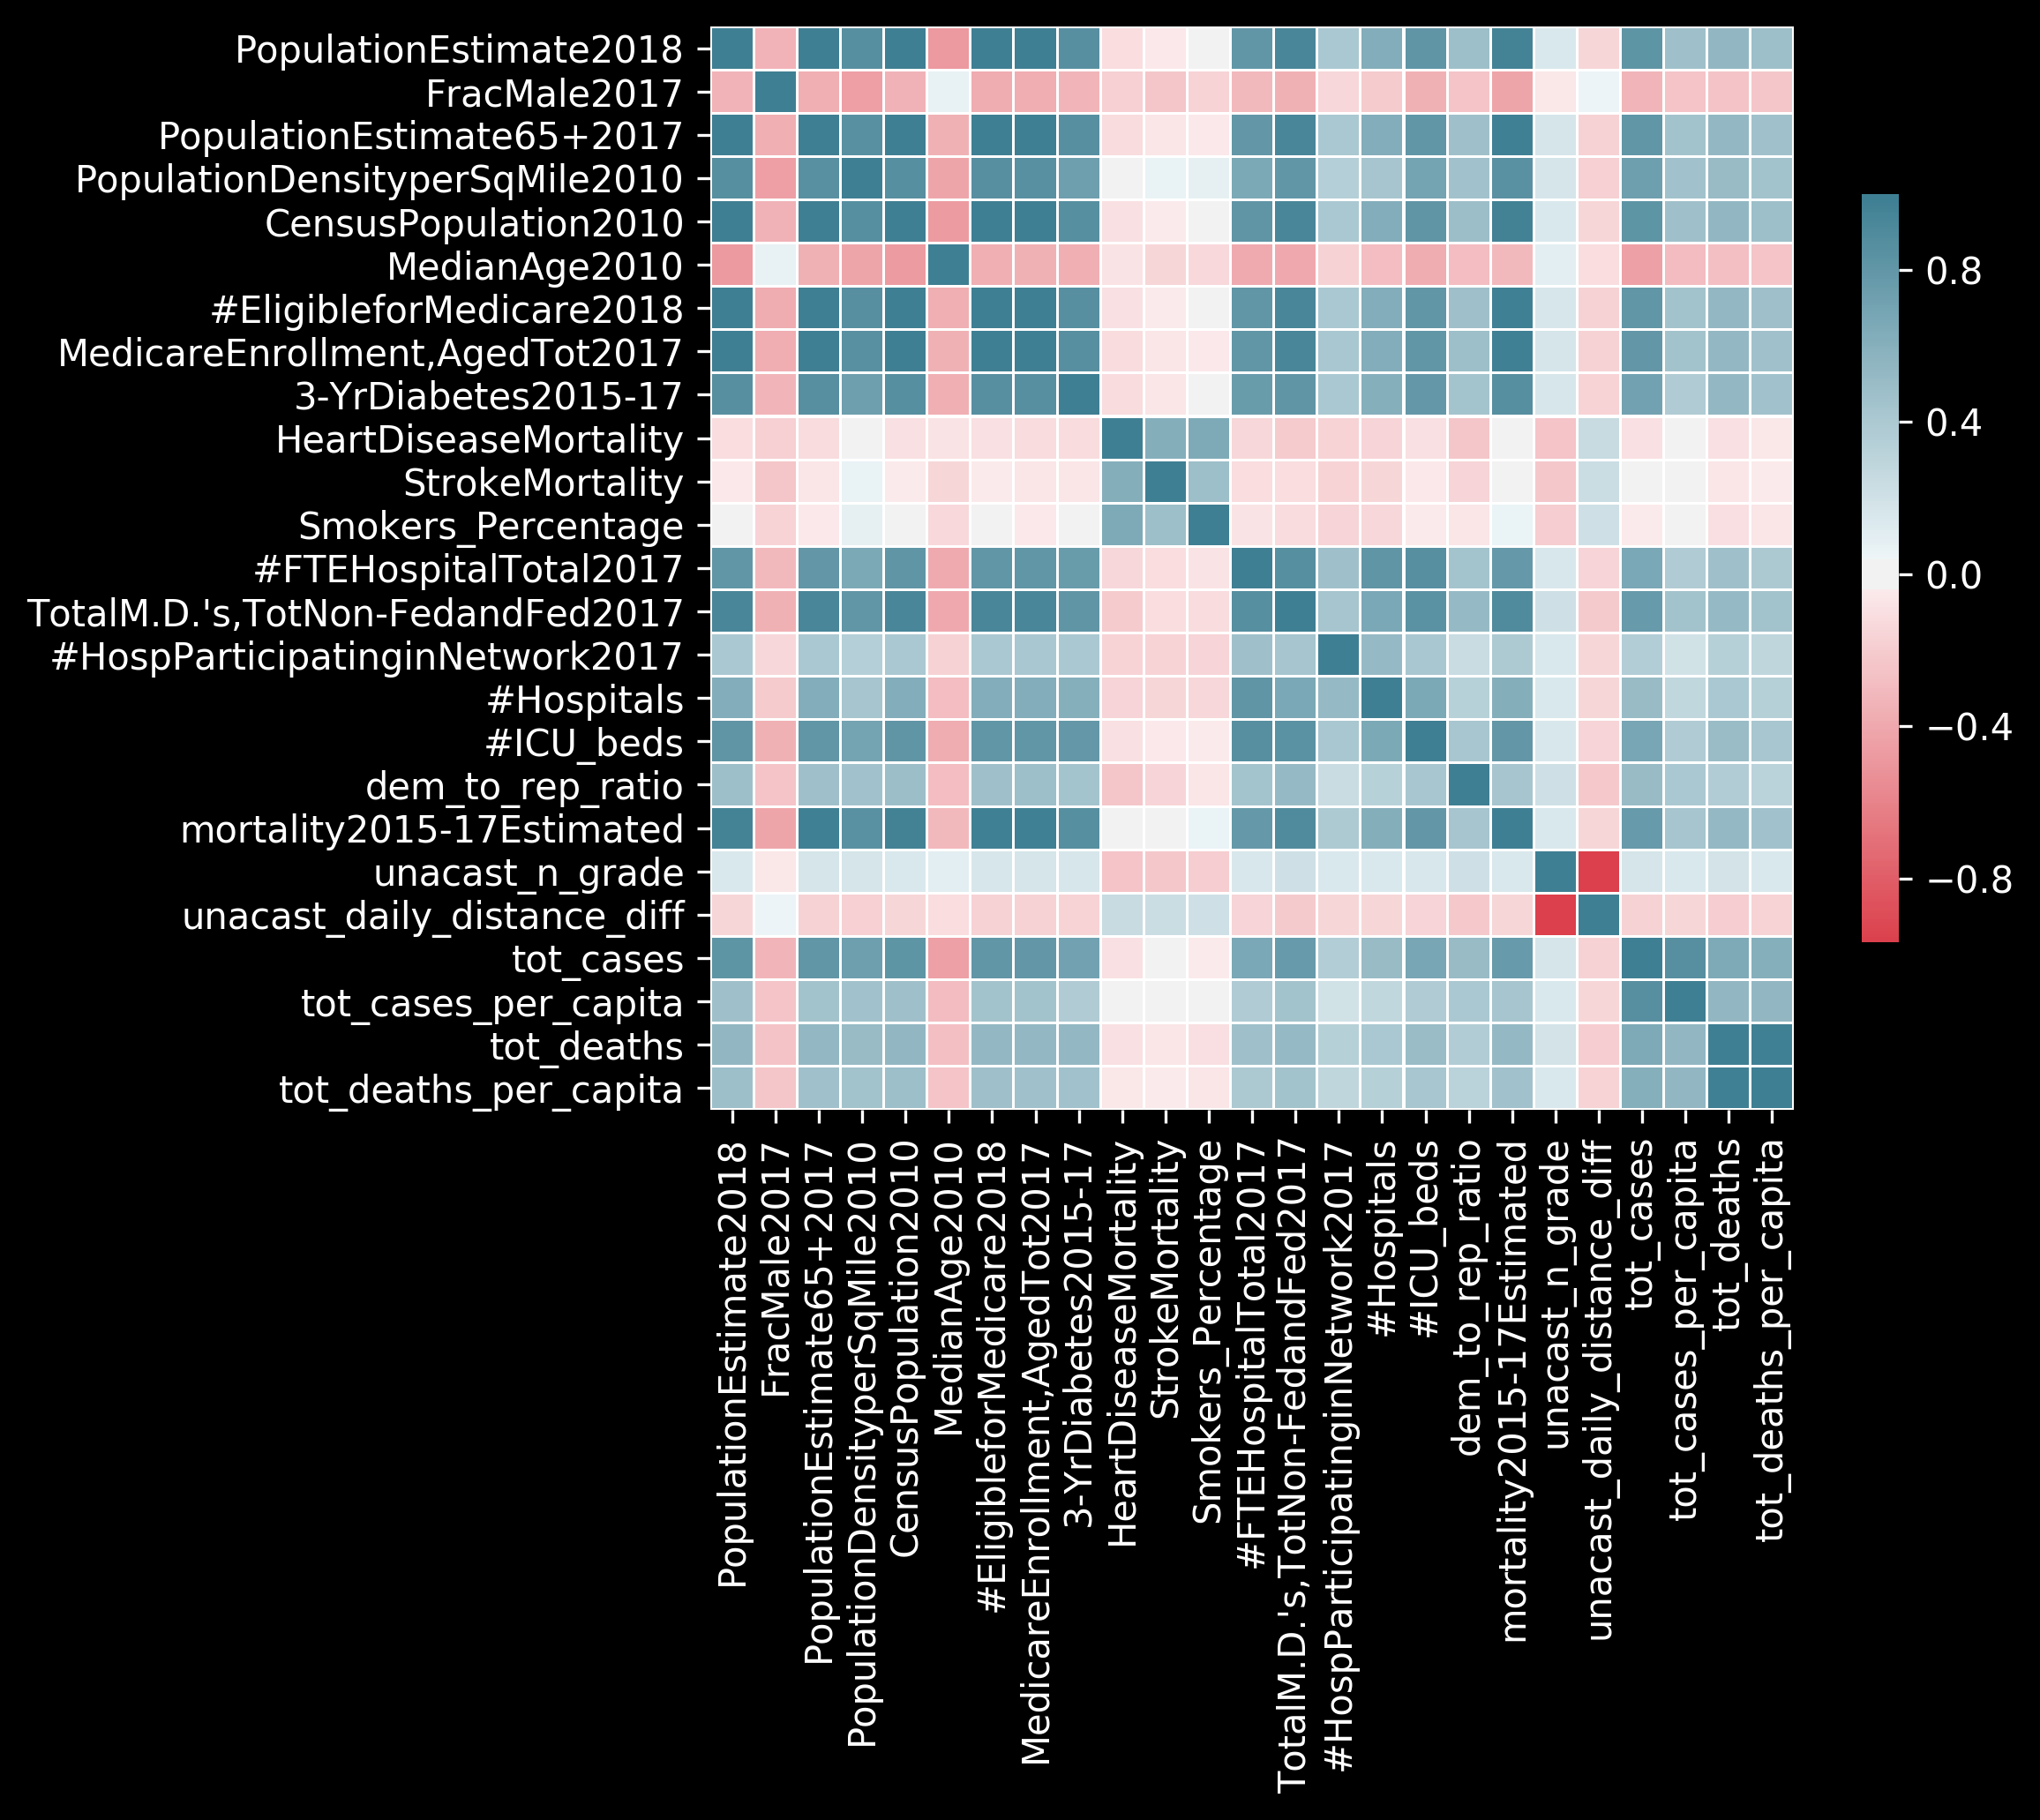

In [20]:
d = df[[k for k in important_vars if not 'PopMale' in k and not 'PopFmle' in k and not 'MortalityAge' in k and not 'PopTotal' in k] + 
        ['tot_cases', 'tot_cases_per_capita', 'tot_deaths', 'tot_deaths_per_capita']]

viz.corrplot(d)
plt.savefig('results/correlations_heatmap.png')
plt.show()

In [ ]:
corrs = d.corr()
keys = np.array(corrs.index)
k = np.where(keys == 'tot_deaths')[0][0]
corrs_row = corrs.iloc[k]
args = np.argsort(corrs_row)
plt.figure(dpi=300, figsize=(6, 5))
plt.barh(keys[args][:-1], corrs_row[args][:-1]) # 1 to drop outcome itself
plt.xlabel('Correlation (spearman) with tot_deaths')
plt.tight_layout()
# plt.savefig('results/correlations.png')
plt.show()

In [ ]:
ks = ['PopulationDensityperSqMile2010', "TotalM.D.'s,TotNon-FedandFed2017", 'unacast_n_grade']
R, C = 1, len(ks)
plt.figure(dpi=300, figsize=(C * 3, R * 3))

for c in range(C):
    plt.subplot(R, C, c + 1)
    if c == 0:
        plt.ylabel('tot_deaths')
    plt.loglog(d[ks[c]], d['tot_deaths'], '.')
    plt.xlabel(ks[c])

plt.tight_layout()
plt.show()

# interactive plots

In [6]:
ks = [k for k in important_vars if not 'PopMale' in k
      and not 'PopFmle' in k
      and not 'MortalityAge' in k]

**individual states no slider**

In [ ]:
# filter by state
for state in ['NY', 'WA', 'CA']:
    d = df[df["StateNameAbbreviation"] == state]

    p = viz_interactive.plot_counties(d, 
                          variable_to_distribute='tot_cases',
                          variables_to_display=ks,
                          state=state,
                          logcolor=False)
    
    output_file(f"results/{state.lower()}.html", mode='inline')
    show(p)
    save(p)

**counties slider**

In [7]:
# add lat and lon to the dataframe
county_lat_lon = pd.read_csv('data/county_pop_centers.csv', dtype={'STATEFP': str, 'COUNTYFP': str})
county_lat_lon['fips'] = (county_lat_lon['STATEFP'] + county_lat_lon['COUNTYFP']).astype(np.int64)
# join to df and rename columns
df = df.join(county_lat_lon.set_index('fips'), on='countyFIPS', how='left').rename(
    columns={'LATITUDE' : 'lat', 'LONGITUDE' : 'lon'}
)

In [18]:
# Just plot the bubbles... 
viz_interactive.plot_counties_slider(df, plot_choropleth=False)

Loading BokehJS ...

In [ ]:
# ...or plot choropleth too. Much slower and the map is less responsive
# read in county geojson
counties_json = json.load(open("data/geojson-counties-fips.json", "r"))
viz_interactive.plot_counties_slider(df, plot_choropleth=True, counties_json=counties_json)

**political leaning**

In [ ]:
# filter by state
for state in ['NY', 'WA', 'CA']:
    d = df[df["StateNameAbbreviation"] == state]

    p = viz_interactive.plot_counties(d, 
                          variable_to_distribute='dem_to_rep_ratio',
                          variables_to_display=ks,
                          state=state,
                          logcolor=False)
    show(p)

**viz curves**

In [ ]:
df_tab = df[['tot_deaths', 'tot_cases', 'CountyName', 'StateName', 
             'PopulationDensityperSqMile2010',
             'deaths', 'cases']].head(12)        
# df_tab = df_tab.rename(columns={'PopulationEstimate2018': 'Population\n(thousands})'})
df_tab = df_tab.rename(columns={'PopulationDensityperSqMile2010': 'PopDensity'})
df_tab = df_tab.rename(columns={'tot_deaths': '#Deaths', 'tot_cases': '#Cases'})
df_tab = df_tab.rename(columns={'CountyName': 'County', 'StateName': 'State'})
print(df_tab.keys())
# df_tab['Population']
keys_table = [k for k in df_tab.keys() if not k in ['deaths', 'cases']]
viz_interactive.viz_curves(df_tab, 
               key_toggle='County',
               keys_table=keys_table,
               filename='results/county_curves.html')
print('done!')